# Data Curation & Integration Project Report

# Introduction

In this project, we aimed to integrate data from various sources related to events, accommodations, and park places in South Tyrol. We obtained the data from the South Tyrol Open Data Hub via a public API, cleaned and processed it, and populated a database with it. We then used Ontop and tools such as Protégé to create an ontology and mappings that represents the domain of interest and connected the ontology to the data in the database. We also deployed a SPARQL endpoint and ran queries. The final outcome of the project is a Streamlit web application that is able to query the VKG and display the results using visualizations.

# Importing Tools

In [2]:
import numpy as np # a library for working with arrays and matrices of numerical data.
import pandas as pd # a library for working with data in a tabular format, similar to a spreadsheet.
from pandas_profiling import ProfileReport # a library for generating a report of the data in a pandas datafr
import json # a library for working with JSON data.
import sparql_dataframe # a library for querying SPARQL endpoints and returning the results as a pandas dataframe.
import matplotlib.pyplot as plt #  a library for creating static visualizations


# Data Extraction 

For this project we are using three data sources from South Tyrol Open Data Hub. In particular, we are interested in accomodations, events and parkplaces in the region. In order to get the data from the Hub, we used the public API and "Get" requests. The following request have been used:

```
GET https://tourism.opendatahub.bz.it/v1/Accommodation?pagesize=5000
GET https://tourism.opendatahub.bz.it/v1/Event?language=en&pagenumber=1&pagesize=5000
GET https://mobility.api.opendatahub.com/v2/flat,node/ParkingStation?limit=10000
```
Data comes in JSON format and need to be unpacked and converted to tabular format (CSV). Results of this section are stored in ./data/raw_csv/

## Event

The event data source represents all the events in the region with related information.

In [4]:
# Read the JSON file and load it into a Pandas DataFrame
df = pd.read_json("./data/event.json")

# Create a new DataFrame from the 'Items' field of the first DataFrame
df2 = pd.DataFrame.from_records(df['Items'])

# Get the column names of the second DataFrame
df2.columns

Index(['Id', 'Pdf', 'Ranc', 'Self', 'Type', '_Meta', 'Active', 'Detail',
       'OrgRID', 'PayMet', 'SignOn', 'Source', 'Ticket', 'Topics', 'DateEnd',
       'Gpstype', 'Hashtag', 'LTSTags', 'Mapping', 'ODHTags', 'SmgTags',
       'Altitude', 'GrpEvent', 'Latitude', 'DateBegin', 'Districts',
       'EventDate', 'GpsPoints', 'Longitude', 'OdhActive', 'Shortname',
       'SmgActive', 'TopicRIDs', 'DistrictId', 'EventPrice', 'LastChange',
       'DistrictIds', 'EventPrices', 'FirstImport', 'HasLanguage',
       'LicenseInfo', 'PublishedOn', 'ContactInfos', 'DistanceInfo',
       'EventBenefit', 'EventBooking', 'ImageGallery', 'LocationInfo',
       'EventDatesEnd', 'NextBeginDate', 'EventPublisher', 'OrganizerInfos',
       'EventDatesBegin', 'EventDateCounter', 'ClassificationRID',
       'EventCrossSelling', 'EventDescAdditional', 'EventAdditionalInfos',
       'AltitudeUnitofMeasure', 'EventOperationScheduleOverview'],
      dtype='object')

In [530]:
#Select only the interesting columns
df3 = df2[['Id', 'Detail', 'PayMet', 'Source', 'DateEnd', 'Latitude', 'DateBegin', 'Longitude', 'Shortname', 'LocationInfo', 'ContactInfos']]
#Generate a index usefull for later merge
df3.reset_index(inplace=True)
df3

,index,Id,Detail,PayMet,Source,DateEnd,Latitude,DateBegin,Longitude,Shortname,LocationInfo,ContactInfos
0,0,BFEB2DDB0FD54AC9BC040053A5514A92_REDUCED,"{'it': {'Title': 'Venosta: La ""valle dei 1000 ...",None,lts,2022-06-01T00:00:00,46.644273,2022-06-01T00:00:00,11.225259,1000-Stufen-Schlucht im Vinschgau,{'TvInfo': {'Id': '5228229151CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': '', 'Vat': None, '..."
1,1,982011E3BE704D22A84F7C2EB40CA8BE_REDUCED,{'it': {'Title': '100 anni banda musicale di c...,None,lts,2023-06-03T00:00:00,46.629600,2023-06-02T00:00:00,10.755800,100 Jahre Musikkapelle Kortsch Jubiläumsfest,{'TvInfo': {'Id': '522822E951CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': 'https://www.musik..."
2,2,429F65276B0144FCB4ADC354A29C1435_REDUCED,{'it': {'Title': '100 anni banda musicale di C...,None,lts,2022-05-28T00:00:00,46.995900,2022-05-28T00:00:00,11.980500,100-Jahr Jubiläum der Musikkapelle Steinhaus,{'TvInfo': {'Id': '522822F751CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': '', 'Vat': None, '..."
3,3,10CF80CE69EC42349E4F0B89191F5944_REDUCED,{'it': {'Title': '100 anni banda musicale di C...,None,lts,2022-05-29T00:00:00,46.995940,2022-05-29T00:00:00,11.980515,100-Jahr Jubiläum der Musikkapelle Steinhaus,{'TvInfo': {'Id': '522822F751CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': '', 'Vat': None, '..."
4,4,9D4618A013144230B8CFF19943335180_REDUCED,{'it': {'Title': '10. Miglio delle prugne a Ba...,None,lts,2022-09-03T00:00:00,46.603100,2022-09-03T00:00:00,11.520300,10. Barbianer Zwetschkenmeile,{'TvInfo': {'Id': '522822A151CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': 'http://www.klause..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,5C4F708C5B5740D6B2A6DB4A5D6919D3_REDUCED,"{'it': {'Title': '41° Marcia Notturna', 'Heade...",None,lts,2016-08-14T00:00:00,46.724500,2016-08-14T00:00:00,12.224300,41. Toblacher Nachtlauf,{'TvInfo': {'Id': '522822A751CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': 'http://www.dobbia..."
96,96,1FC5A2ECA6A14AF2B259F529D46FE41F_REDUCED,{'it': {'Title': '41°Gran Fondo Dobbiaco - Cor...,None,lts,2018-02-04T00:00:00,46.735900,2018-02-03T00:00:00,12.222500,41. Volkslanglauf Toblach-Cortina: 50 km Class...,{'TvInfo': {'Id': '522822A751CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': 'http://www.dobbia..."
97,97,6D2C08F628F3453C87C25FCB2625A10F_REDUCED,{'it': {'Title': '43° concerto della banda mus...,None,lts,2022-04-30T00:00:00,46.626700,2022-04-30T00:00:00,10.772900,43. Festkonzert der Musikkapelle Kortsch,{'TvInfo': {'Id': '522822E951CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': 'https://www.musik..."
98,98,398AAACC7943414E86A866B5ABB8281A_REDUCED,"{'it': {'Title': '44° Carnevale di Laives', 'H...",None,lts,2023-02-12T00:00:00,46.427100,2023-02-12T00:00:00,11.337200,44. Leiferer Fasching,{'TvInfo': {'Id': '522822B351CA11D18F1400A0242...,"{'it': {'Tax': None, 'Url': 'http://www.carnev..."


In [531]:
#Normalize the data from the json in order to extract it 
detail = pd.json_normalize(df3['Detail'])
#Rename the column Title
detail.rename(columns={"it.Title": "Title"}, inplace=True)
detail = detail[['Title']]
#Generate a index
detail.reset_index(inplace=True)
detail

,index,Title
0,0,"Venosta: La ""valle dei 1000 gradini"""
1,1,100 anni banda musicale di corzes
2,2,100 anni banda musicale di Cadipietra - festa
3,3,100 anni banda musicale di Cadipietra - festa
4,4,10. Miglio delle prugne a Barbiano
...,...,...
95,95,41° Marcia Notturna
96,96,41°Gran Fondo Dobbiaco - Cortina: 50 km Classi...
97,97,43° concerto della banda musicale di Corzes
98,98,44° Carnevale di Laives


In [532]:
# 
munici = pd.json_normalize(df3['LocationInfo'])
#Rename the column City
munici.rename(columns={"MunicipalityInfo.Name.it": "City"}, inplace=True)
munici = munici[['City']]
munici.reset_index(inplace=True)
munici
munici

,index,City
0,0,Avelengo
1,1,Silandro
2,2,Valle Aurina
3,3,Valle Aurina
4,4,Barbiano
...,...,...
95,95,Dobbiaco
96,96,Dobbiaco
97,97,Silandro
98,98,Laives


In [533]:
#Normalize the data from the json in order to extract it
zip = pd.json_normalize(df3['ContactInfos'])
#Rename the column Zip
zip.rename(columns={"it.ZipCode": "Zip"}, inplace=True)
zip = zip[['Zip']]
zip.reset_index(inplace=True)
zip

,index,Zip
0,0,39010
1,1,39028
2,2,39030
3,3,39030
4,4,39040
...,...,...
95,95,39034
96,96,39034
97,97,39028
98,98,39055


In [534]:
#Merge using the index 
city = pd.merge(munici, zip)
city

,index,City,Zip
0,0,Avelengo,39010
1,1,Silandro,39028
2,2,Valle Aurina,39030
3,3,Valle Aurina,39030
4,4,Barbiano,39040
...,...,...,...
95,95,Dobbiaco,39034
96,96,Dobbiaco,39034
97,97,Silandro,39028
98,98,Laives,39055


In [535]:
#Merge using the index
detail = pd.merge(detail, city)
detail

,index,Title,City,Zip
0,0,"Venosta: La ""valle dei 1000 gradini""",Avelengo,39010
1,1,100 anni banda musicale di corzes,Silandro,39028
2,2,100 anni banda musicale di Cadipietra - festa,Valle Aurina,39030
3,3,100 anni banda musicale di Cadipietra - festa,Valle Aurina,39030
4,4,10. Miglio delle prugne a Barbiano,Barbiano,39040
...,...,...,...,...
95,95,41° Marcia Notturna,Dobbiaco,39034
96,96,41°Gran Fondo Dobbiaco - Cortina: 50 km Classi...,Dobbiaco,39034
97,97,43° concerto della banda musicale di Corzes,Silandro,39028
98,98,44° Carnevale di Laives,Laives,39055


In [536]:
#we obtain as result an event table that needs to be cleaned 
final = pd.merge(df3, detail)
event = final[['Id', 'Source', 'DateBegin', 'DateEnd', 'Latitude', 'Longitude', 'Shortname', 'Title', 'City', 'Zip']]
event

,Id,Source,DateBegin,DateEnd,Latitude,Longitude,Shortname,Title,City,Zip
0,BFEB2DDB0FD54AC9BC040053A5514A92_REDUCED,lts,2022-06-01T00:00:00,2022-06-01T00:00:00,46.644273,11.225259,1000-Stufen-Schlucht im Vinschgau,"Venosta: La ""valle dei 1000 gradini""",Avelengo,39010
1,982011E3BE704D22A84F7C2EB40CA8BE_REDUCED,lts,2023-06-02T00:00:00,2023-06-03T00:00:00,46.629600,10.755800,100 Jahre Musikkapelle Kortsch Jubiläumsfest,100 anni banda musicale di corzes,Silandro,39028
2,429F65276B0144FCB4ADC354A29C1435_REDUCED,lts,2022-05-28T00:00:00,2022-05-28T00:00:00,46.995900,11.980500,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa,Valle Aurina,39030
3,10CF80CE69EC42349E4F0B89191F5944_REDUCED,lts,2022-05-29T00:00:00,2022-05-29T00:00:00,46.995940,11.980515,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa,Valle Aurina,39030
4,9D4618A013144230B8CFF19943335180_REDUCED,lts,2022-09-03T00:00:00,2022-09-03T00:00:00,46.603100,11.520300,10. Barbianer Zwetschkenmeile,10. Miglio delle prugne a Barbiano,Barbiano,39040
...,...,...,...,...,...,...,...,...,...,...
95,5C4F708C5B5740D6B2A6DB4A5D6919D3_REDUCED,lts,2016-08-14T00:00:00,2016-08-14T00:00:00,46.724500,12.224300,41. Toblacher Nachtlauf,41° Marcia Notturna,Dobbiaco,39034
96,1FC5A2ECA6A14AF2B259F529D46FE41F_REDUCED,lts,2018-02-03T00:00:00,2018-02-04T00:00:00,46.735900,12.222500,41. Volkslanglauf Toblach-Cortina: 50 km Class...,41°Gran Fondo Dobbiaco - Cortina: 50 km Classi...,Dobbiaco,39034
97,6D2C08F628F3453C87C25FCB2625A10F_REDUCED,lts,2022-04-30T00:00:00,2022-04-30T00:00:00,46.626700,10.772900,43. Festkonzert der Musikkapelle Kortsch,43° concerto della banda musicale di Corzes,Silandro,39028
98,398AAACC7943414E86A866B5ABB8281A_REDUCED,lts,2023-02-12T00:00:00,2023-02-12T00:00:00,46.427100,11.337200,44. Leiferer Fasching,44° Carnevale di Laives,Laives,39055


In [537]:
#Export the raw data in csv format
event.to_csv("./data/raw_csv/event.csv", index=False)

## Accomodation

The accomodation data source represents all the possible accomodations in the region with related information.

In [538]:
# Read the JSON file and load it into a Pandas DataFrame
df = pd.read_json("./data/accomodation.json")
# Create a new DataFrame from the 'Items' field of the first DataFrame
df2 = pd.DataFrame.from_records(df['Items'])
df2.columns

Index(['Id', 'Self', 'HgvId', '_Meta', 'Active', 'Source', 'Gpstype',
       'HasRoom', 'Mapping', 'ODHTags', 'SmgTags', 'AccoType', 'Altitude',
       'BadgeIds', 'BoardIds', 'Features', 'Latitude', 'ThemeIds', 'GpsPoints',
       'IsCamping', 'Longitude', 'OdhActive', 'Shortname', 'SmgActive',
       'AccoBadges', 'AccoBoards', 'AccoDetail', 'AccoThemes', 'AccoTypeId',
       'DistrictId', 'IsBookable', 'LastChange', 'FirstImport', 'HasLanguage',
       'LicenseInfo', 'PublishedOn', 'AccoCategory', 'AccoRoomInfo',
       'DistanceInfo', 'GastronomyId', 'HasApartment', 'ImageGallery',
       'IsGastronomy', 'LocationInfo', 'MainLanguage', 'AccoCategoryId',
       'IndependentData', 'IsAccommodation', 'TourismVereinId',
       'MssResponseShort', 'MarketingGroupIds', 'AccoBookingChannel',
       'SpecialFeaturesIds', 'AccoSpecialFeatures', 'AltitudeUnitofMeasure'],
      dtype='object')

In [539]:
#Select only the interesting columns
df3 = df2[['Id', 'Source', 'HasRoom', 'AccoTypeId', 'Latitude', 'AccoDetail', 'Longitude', 'Shortname', 'IsBookable']]
#generate index for later merge
df3.reset_index(inplace=True)
df3

,index,Id,Source,HasRoom,AccoTypeId,Latitude,AccoDetail,Longitude,Shortname,IsBookable
0,0,5CEA544EE34639034F07B79D4AEEB603_REDUCED,LTS,False,BedBreakfast,46.477851,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3910...",11.369939,1100 APARTMENT,False
1,1,2657B7CBCB85380B253D2FBE28AF100E_REDUCED,LTS,True,BedBreakfast,46.615101,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3901...",11.143296,1477 Reichhalter,False
2,2,5E4BEFD440200CE4732A7FA30897C402_REDUCED,LTS,False,BedBreakfast,46.902639,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3904...",11.461289,164 apt.,False
3,3,14AF6F5E67CBEAC34F3223D8DE20D08D_REDUCED,LTS,False,BedBreakfast,46.679733,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3901...",11.149205,18,False
4,4,C93CE627A8497E697C657CF53028F9D2_REDUCED,LTS,False,HotelPension,46.660809,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3901...",11.180298,360 Grad - Bundeswehr Sozialwerk,False
...,...,...,...,...,...,...,...,...,...,...
4995,4995,E9207239053711D4858B00A0244638B0_REDUCED,LTS,False,Farm,46.414400,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3905...",11.233100,Helmut Andergassen,False
4996,4996,E650C0D53DC111D29536004F56000ECA_REDUCED,LTS,False,Farm,46.758332,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3903...",12.042045,Henglerhof,False
4997,4997,ED06EC32FDB15A535FFD5684532BAC16_REDUCED,LTS,False,Farm,46.426005,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3905...",11.252099,Hermann Gatscher,False
4998,4998,BE86941F9712FA664B0DF5E232E6D677_REDUCED,LTS,False,BedBreakfast,46.617405,"{'de': {'Fax': None, 'Vat': None, 'Zip': '3901...",11.134018,Herrenhaus am Grübl,False


In [540]:
#Normalize the accoDetail to extract the data
accDetail = pd.json_normalize(df3['AccoDetail'])
accDetail = accDetail[[col for col in accDetail if col.startswith('it.')]]

In [541]:
#remove all columns starting with .it
accDetail.columns = accDetail.columns.str.replace('^it.', '')
#generate index
accDetail.reset_index(inplace=True)
accDetail

/var/folders/y4/87dlj0md68x2q0txn3s2jtmh0000gn/T/ipykernel_66338/3760057915.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  accDetail.columns = accDetail.columns.str.replace('^it.', '')


,index,Fax,Vat,Zip,City,Name,Email,Phone,Mobile,Street,Website,Language,Lastname,Longdesc,Firstname,Shortdesc,CountryCode,NameAddition
0,0,None,None,39100,Bolzano,1100 APARTMENT,None,+39 353 3026699,None,Colle 1/C,None,it,None,None,None,None,IT,None
1,1,None,None,39011,Lana,1477 Reichhalter,None,+39 0473 051050,None,Via Macello 2,http://www.1477reichhalter.com,it,None,None,None,None,IT,None
2,2,None,None,39049,Prati di Vizze,164 apt.,None,,None,Hintere Gasse 164 B,http://www.164apt.com,it,None,None,None,None,IT,None
3,3,None,None,39012,Merano,18,None,+39 339 1055598,None,Via Laurin 32,None,it,None,None,None,None,IT,None
4,4,None,None,39012,Merano,360 Grad - Bundeswehr Sozialwerk,None,+39 0473 232345,None,Via Dante 110,http://www.bundeswehr-sozialwerk.de,it,None,None,None,None,IT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,None,None,39052,Caldaro,Helmut Andergassen,None,+39 0471 964252,None,Pozzo 53,http://www.andergassen-kaltern.it,it,None,None,None,None,IT,None
4996,4996,None,None,39030,Valdaora di Sopra,Henglerhof,None,+39 0474 496016,None,"Via del Borgo, 17",https://www.henglerhof.com,it,None,None,None,None,IT,None
4997,4997,None,None,39052,Caldaro,Hermann Gatscher,None,+39 349 4655718,None,Pianizza di Sotto 10,None,it,None,None,None,None,IT,None
4998,4998,None,None,39011,Lana,Herrenhaus am Grübl,None,+39 339 3607647,None,Via Ultimo 17,None,it,None,None,None,None,IT,None


In [542]:
#merge the date on the index
accomodationFinal = pd.merge(df3, accDetail)
#remove unnecessary column
accomodationFinal = accomodationFinal.drop(columns=['AccoDetail', 'index'])
accomodationFinal

,Id,Source,HasRoom,AccoTypeId,Latitude,Longitude,Shortname,IsBookable,Fax,Vat,...,Mobile,Street,Website,Language,Lastname,Longdesc,Firstname,Shortdesc,CountryCode,NameAddition
0,5CEA544EE34639034F07B79D4AEEB603_REDUCED,LTS,False,BedBreakfast,46.477851,11.369939,1100 APARTMENT,False,None,None,...,None,Colle 1/C,None,it,None,None,None,None,IT,None
1,2657B7CBCB85380B253D2FBE28AF100E_REDUCED,LTS,True,BedBreakfast,46.615101,11.143296,1477 Reichhalter,False,None,None,...,None,Via Macello 2,http://www.1477reichhalter.com,it,None,None,None,None,IT,None
2,5E4BEFD440200CE4732A7FA30897C402_REDUCED,LTS,False,BedBreakfast,46.902639,11.461289,164 apt.,False,None,None,...,None,Hintere Gasse 164 B,http://www.164apt.com,it,None,None,None,None,IT,None
3,14AF6F5E67CBEAC34F3223D8DE20D08D_REDUCED,LTS,False,BedBreakfast,46.679733,11.149205,18,False,None,None,...,None,Via Laurin 32,None,it,None,None,None,None,IT,None
4,C93CE627A8497E697C657CF53028F9D2_REDUCED,LTS,False,HotelPension,46.660809,11.180298,360 Grad - Bundeswehr Sozialwerk,False,None,None,...,None,Via Dante 110,http://www.bundeswehr-sozialwerk.de,it,None,None,None,None,IT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,E9207239053711D4858B00A0244638B0_REDUCED,LTS,False,Farm,46.414400,11.233100,Helmut Andergassen,False,None,None,...,None,Pozzo 53,http://www.andergassen-kaltern.it,it,None,None,None,None,IT,None
4996,E650C0D53DC111D29536004F56000ECA_REDUCED,LTS,False,Farm,46.758332,12.042045,Henglerhof,False,None,None,...,None,"Via del Borgo, 17",https://www.henglerhof.com,it,None,None,None,None,IT,None
4997,ED06EC32FDB15A535FFD5684532BAC16_REDUCED,LTS,False,Farm,46.426005,11.252099,Hermann Gatscher,False,None,None,...,None,Pianizza di Sotto 10,None,it,None,None,None,None,IT,None
4998,BE86941F9712FA664B0DF5E232E6D677_REDUCED,LTS,False,BedBreakfast,46.617405,11.134018,Herrenhaus am Grübl,False,None,None,...,None,Via Ultimo 17,None,it,None,None,None,None,IT,None


In [543]:
#Export the raw dataset as a csv
accomodationFinal.to_csv("./data/raw_csv/accomodation.csv", index=False)

## Parkplace

The parkplace data source represents all the parkplaces in the region with related information.

In [544]:
#import the dataset as json 
df = pd.read_json("./data/parkplace.json")
df2 = pd.DataFrame.from_records(df['data'])
df2.reset_index(inplace=True)
df2

,index,sactive,savailable,scode,scoordinate,smetadata,sname,sorigin,stype
0,0,False,True,102,"{'x': 11.356305, 'y': 46.496449, 'srid': 4326}","{'state': 1, 'capacity': 233, 'mainaddress': '...",P02 - City parking,FAMAS,ParkingStation
1,1,False,True,107,"{'x': 11.351793, 'y': 46.502958, 'srid': 4326}","{'state': 1, 'capacity': 170, 'mainaddress': '...",P07 - Mareccio,FAMAS,ParkingStation
2,2,False,True,112,"{'x': 11.338545, 'y': 46.497757, 'srid': 4326}","{'state': 1, 'capacity': 120, 'mainaddress': '...",P12 - Piazza Tribunale,FAMAS,ParkingStation
3,3,False,True,113,"{'x': 11.338206, 'y': 46.498294, 'srid': 4326}","{'state': 1, 'capacity': 490, 'mainaddress': '...",P13 - Direzional 2,FAMAS,ParkingStation
4,4,False,True,420,"{'x': 11.347308, 'y': 46.494624, 'srid': 4326}","{'state': 1, 'capacity': 70, 'mainaddress': 'V...",@LUNA NOI Technologie Park(test),Legocity,ParkingStation
5,5,False,True,520,"{'x': 11.332848, 'y': 46.479249, 'srid': 4326}","{'state': 1, 'capacity': 50, 'mainaddress': 'V...",@LUNA Parking-Bikesharing(test),Legocity,ParkingStation
6,6,True,True,103,"{'x': 11.355115, 'y': 46.497805, 'srid': 4326}","{'capacity': 403, 'municipality': 'Bolzano - B...",P03 - Piazza Walther,FAMAS,ParkingStation
7,7,True,True,104,"{'x': 11.358216, 'y': 46.500551, 'srid': 4326}","{'capacity': 150, 'municipality': 'Bolzano - B...",P04 - Luna via Molini,FAMAS,ParkingStation
8,8,True,True,105,"{'x': 11.357255, 'y': 46.498174, 'srid': 4326}","{'capacity': 90, 'municipality': 'Bolzano - Bo...",P05 - Laurin,FAMAS,ParkingStation
9,9,True,True,106,"{'x': 11.358907, 'y': 46.497134, 'srid': 4326}","{'capacity': 459, 'municipality': 'Bolzano - B...",P06 - Central Parking via Renon,FAMAS,ParkingStation


In [545]:
#Normalize and extract data 
coordinate = pd.json_normalize(df2['scoordinate'])
coordinate.drop(columns=['srid'], inplace=True)
#generate index for later merge
coordinate.reset_index(inplace=True)
coordinate.rename(columns={"y": "Latitude", "x": "Longitude"}, inplace=True)
coordinate

,index,Longitude,Latitude
0,0,11.356305,46.496449
1,1,11.351793,46.502958
2,2,11.338545,46.497757
3,3,11.338206,46.498294
4,4,11.347308,46.494624
5,5,11.332848,46.479249
6,6,11.355115,46.497805
7,7,11.358216,46.500551
8,8,11.357255,46.498174
9,9,11.358907,46.497134


In [546]:
#Merge the data and remove unnecessary column 
parkFinal = pd.merge(df2, coordinate)
parkFinal.drop(columns=['scoordinate', 'smetadata', 'index'], inplace=True)
parkFinal

,sactive,savailable,scode,sname,sorigin,stype,Longitude,Latitude
0,False,True,102,P02 - City parking,FAMAS,ParkingStation,11.356305,46.496449
1,False,True,107,P07 - Mareccio,FAMAS,ParkingStation,11.351793,46.502958
2,False,True,112,P12 - Piazza Tribunale,FAMAS,ParkingStation,11.338545,46.497757
3,False,True,113,P13 - Direzional 2,FAMAS,ParkingStation,11.338206,46.498294
4,False,True,420,@LUNA NOI Technologie Park(test),Legocity,ParkingStation,11.347308,46.494624
5,False,True,520,@LUNA Parking-Bikesharing(test),Legocity,ParkingStation,11.332848,46.479249
6,True,True,103,P03 - Piazza Walther,FAMAS,ParkingStation,11.355115,46.497805
7,True,True,104,P04 - Luna via Molini,FAMAS,ParkingStation,11.358216,46.500551
8,True,True,105,P05 - Laurin,FAMAS,ParkingStation,11.357255,46.498174
9,True,True,106,P06 - Central Parking via Renon,FAMAS,ParkingStation,11.358907,46.497134


In [547]:
#export the raw dataset 
parkFinal.to_csv("./data/raw_csv/parkplace.csv", index=False)

# EDA

EDA stands for Exploratory Data Analysis. It is an approach to analyzing and understanding data through visual and statistical methods. The goal of EDA is to discover patterns, features, and relationships in data that can help inform further analysis and modeling.

During an EDA, we typically look at the structure and overall characteristics of the data, such as the number of records, data types, and missing values. Visualization techniques, such as histograms, scatter plots, and box plots, are then used to explore the distribution and relationships between different variables in the data. Another important aspect of EDA is looking for outliers and anomalies in the data, which can indicate errors or inconsistencies that need to be addressed.

EDA also includes summarizing the main characteristics of the data using measures of central tendency(mean, median, mode) and spread (variance, standard deviation) and also checking if the data is normally distributed or not.

Overall, EDA is an iterative process that helps analysts gain a deeper understanding of the data and identify important insights that can inform further analysis and modeling.

For the EDA phase we use the Pandas Profiling library presented during the course. The reports generated are stored in `./EDA/`. The first part of this section reports the code to generate the reports, the second part shows how we used the reports to further clean data.

In [ ]:
event = pd.read_csv("./data/raw_csv/event.csv")
profile = ProfileReport(event, title="Event")
#will create an interactive html file that can be opened in any browser and you can explore the data with different interactive visualizations and statistics
profile.to_file("./EDA/event.html")

In [ ]:
accomodation = pd.read_csv("./data/raw_csv/accomodation.csv")
profile = ProfileReport(accomodation, title="Accomodation")
#will create an interactive html file that can be opened in any browser and you can explore the data with different interactive visualizations and statistics
profile.to_file("./EDA/accomodation.html")

In [ ]:
parkplace = pd.read_csv("./data/raw_csv/parkplace.csv")
profile = ProfileReport(parkplace, title="Parkplace")
#will create an interactive html file that can be opened in any browser and you can explore the data with different interactive visualizations and statistics
profile.to_file("./EDA/parkplace.html") 

Based on the EDA reports, we found that the accommodation dataset contained several columns that were not useful for our analysis. Upon closer inspection, we discovered that the attributes "Fax", "Vat", "Email", "Mobile", "Lastname", "Longdesc", "Firstname", "Shortdesc", "NameAddition" contained 100% null values. This means that these attributes don't contain any useful information and can be dropped.

Event and parkplace datasets don't contain 100% nulls attributes and there were no columns to discard.

Overall, the EDA report helped us to identify any issues with the data and take appropriate actions to make it more useful for the next steps.

In [552]:
# event is fine
event

,Id,Source,DateBegin,DateEnd,Latitude,Longitude,Shortname,Title,City,Zip
0,BFEB2DDB0FD54AC9BC040053A5514A92_REDUCED,lts,2022-06-01T00:00:00,2022-06-01T00:00:00,46.644273,11.225259,1000-Stufen-Schlucht im Vinschgau,"Venosta: La ""valle dei 1000 gradini""",Avelengo,39010.0
1,982011E3BE704D22A84F7C2EB40CA8BE_REDUCED,lts,2023-06-02T00:00:00,2023-06-03T00:00:00,46.629600,10.755800,100 Jahre Musikkapelle Kortsch Jubiläumsfest,100 anni banda musicale di corzes,Silandro,39028.0
2,429F65276B0144FCB4ADC354A29C1435_REDUCED,lts,2022-05-28T00:00:00,2022-05-28T00:00:00,46.995900,11.980500,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa,Valle Aurina,39030.0
3,10CF80CE69EC42349E4F0B89191F5944_REDUCED,lts,2022-05-29T00:00:00,2022-05-29T00:00:00,46.995940,11.980515,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa,Valle Aurina,39030.0
4,9D4618A013144230B8CFF19943335180_REDUCED,lts,2022-09-03T00:00:00,2022-09-03T00:00:00,46.603100,11.520300,10. Barbianer Zwetschkenmeile,10. Miglio delle prugne a Barbiano,Barbiano,39040.0
...,...,...,...,...,...,...,...,...,...,...
95,5C4F708C5B5740D6B2A6DB4A5D6919D3_REDUCED,lts,2016-08-14T00:00:00,2016-08-14T00:00:00,46.724500,12.224300,41. Toblacher Nachtlauf,41° Marcia Notturna,Dobbiaco,39034.0
96,1FC5A2ECA6A14AF2B259F529D46FE41F_REDUCED,lts,2018-02-03T00:00:00,2018-02-04T00:00:00,46.735900,12.222500,41. Volkslanglauf Toblach-Cortina: 50 km Class...,41°Gran Fondo Dobbiaco - Cortina: 50 km Classi...,Dobbiaco,39034.0
97,6D2C08F628F3453C87C25FCB2625A10F_REDUCED,lts,2022-04-30T00:00:00,2022-04-30T00:00:00,46.626700,10.772900,43. Festkonzert der Musikkapelle Kortsch,43° concerto della banda musicale di Corzes,Silandro,39028.0
98,398AAACC7943414E86A866B5ABB8281A_REDUCED,lts,2023-02-12T00:00:00,2023-02-12T00:00:00,46.427100,11.337200,44. Leiferer Fasching,44° Carnevale di Laives,Laives,39055.0


In [553]:
accomodation.drop(columns=["Fax", "Vat", "Email", "Mobile", "Lastname", "Longdesc", "Firstname", "Shortdesc", "NameAddition"], inplace=True)
accomodation.to_csv("./data/cleaned_csv/accomodation_clean.csv", index=False)

In [554]:
accomodation

,Id,Source,HasRoom,AccoTypeId,Latitude,Longitude,Shortname,IsBookable,Zip,City,Name,Phone,Street,Website,Language,CountryCode
0,5CEA544EE34639034F07B79D4AEEB603_REDUCED,LTS,False,BedBreakfast,46.477851,11.369939,1100 APARTMENT,False,39100.0,Bolzano,1100 APARTMENT,+39 353 3026699,Colle 1/C,NaN,it,IT
1,2657B7CBCB85380B253D2FBE28AF100E_REDUCED,LTS,True,BedBreakfast,46.615101,11.143296,1477 Reichhalter,False,39011.0,Lana,1477 Reichhalter,+39 0473 051050,Via Macello 2,http://www.1477reichhalter.com,it,IT
2,5E4BEFD440200CE4732A7FA30897C402_REDUCED,LTS,False,BedBreakfast,46.902639,11.461289,164 apt.,False,39049.0,Prati di Vizze,164 apt.,NaN,Hintere Gasse 164 B,http://www.164apt.com,it,IT
3,14AF6F5E67CBEAC34F3223D8DE20D08D_REDUCED,LTS,False,BedBreakfast,46.679733,11.149205,18,False,39012.0,Merano,18,+39 339 1055598,Via Laurin 32,NaN,it,IT
4,C93CE627A8497E697C657CF53028F9D2_REDUCED,LTS,False,HotelPension,46.660809,11.180298,360 Grad - Bundeswehr Sozialwerk,False,39012.0,Merano,360 Grad - Bundeswehr Sozialwerk,+39 0473 232345,Via Dante 110,http://www.bundeswehr-sozialwerk.de,it,IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,E9207239053711D4858B00A0244638B0_REDUCED,LTS,False,Farm,46.414400,11.233100,Helmut Andergassen,False,39052.0,Caldaro,Helmut Andergassen,+39 0471 964252,Pozzo 53,http://www.andergassen-kaltern.it,it,IT
4996,E650C0D53DC111D29536004F56000ECA_REDUCED,LTS,False,Farm,46.758332,12.042045,Henglerhof,False,39030.0,Valdaora di Sopra,Henglerhof,+39 0474 496016,"Via del Borgo, 17",https://www.henglerhof.com,it,IT
4997,ED06EC32FDB15A535FFD5684532BAC16_REDUCED,LTS,False,Farm,46.426005,11.252099,Hermann Gatscher,False,39052.0,Caldaro,Hermann Gatscher,+39 349 4655718,Pianizza di Sotto 10,NaN,it,IT
4998,BE86941F9712FA664B0DF5E232E6D677_REDUCED,LTS,False,BedBreakfast,46.617405,11.134018,Herrenhaus am Grübl,False,39011.0,Lana,Herrenhaus am Grübl,+39 339 3607647,Via Ultimo 17,NaN,it,IT


In [555]:
# parkplace is fine
parkplace

,sactive,savailable,scode,sname,sorigin,stype,Longitude,Latitude
0,False,True,102,P02 - City parking,FAMAS,ParkingStation,11.356305,46.496449
1,False,True,107,P07 - Mareccio,FAMAS,ParkingStation,11.351793,46.502958
2,False,True,112,P12 - Piazza Tribunale,FAMAS,ParkingStation,11.338545,46.497757
3,False,True,113,P13 - Direzional 2,FAMAS,ParkingStation,11.338206,46.498294
4,False,True,420,@LUNA NOI Technologie Park(test),Legocity,ParkingStation,11.347308,46.494624
5,False,True,520,@LUNA Parking-Bikesharing(test),Legocity,ParkingStation,11.332848,46.479249
6,True,True,103,P03 - Piazza Walther,FAMAS,ParkingStation,11.355115,46.497805
7,True,True,104,P04 - Luna via Molini,FAMAS,ParkingStation,11.358216,46.500551
8,True,True,105,P05 - Laurin,FAMAS,ParkingStation,11.357255,46.498174
9,True,True,106,P06 - Central Parking via Renon,FAMAS,ParkingStation,11.358907,46.497134


The resulting csv from this steps are stored in `./data/cleaned_csv/`

# Dependency & Unique Columns Discovery

In this section we make use of the Metanome tool to investigate about possible FD, IND, and UCC in the datasets from the previous steps.

FD stands for Functional Dependency, which is a relationship between two sets of attributes in a database table. An FD states that a set of attributes (the determinant set) uniquely determines another set of attributes (the dependent set). In other words, for each value of the determinant set, there is a unique value of the dependent set. FDs are used to ensure the integrity and consistency of data in a database. To discover FDs we used the TANE algorithm.

IND stands for Inclusion Dependency. An inclusion dependency (IND) is a constraint between two relations, specifying that one relation's set of rows must be a subset of the other relation's set of rows. It is used to ensure that the data in a table is consistent with the data in another table. To discover INDs we used the BINDER algorithm.

UCC stands for Unique Column Combination. It is a constraint that ensures that a combination of one or more columns in a table has unique values. UCC ensures that no duplicate data is stored in the table and can be used to improve query performance by creating indexes on the UCC columns. To discover UCCs we used the HyUCC algorithm.

All of these concepts are important in database design as they help to ensure data integrity, consistency, and uniqueness of data. They help to reduce data redundancy and improve the performance of database queries.

The following image represnts an example of the output from Metanome to discover FDs from the event dataset:

<img src="./PROFILING/event_1.png" alt="FDs with Metanome" style="height:500px;">


Based on tha EDA and Dependency Discovery steps, we designed the final schema for the PostgreSQL database that will host the data. The schema is represented in the following image and we created the database with the script in `./CreateScript.sql`

<img src="./IMG/DB_Schema.png" alt="Database Schema" style="height:600px;">

# Data Preparation & DB Population

In this section we prepared the data to populate the database. In particular, we created two new tables, Date and Location, with values from the alredy existing attributes. We dropped duplicates and created referencial constraints to guarantee consistency. 

The resulting tables from this step, stored in `./data/postProcessed_csv/`, were used to populate the database using the PSQL command line tool. In particular we used the following command:

```
COPY <table name> FROM '<csv absolute path>' DELIMITER ',' CSV HEADER;
```

For example:
```
COPY events FROM './data/postProcessed_csv/event.csv' DELIMITER ',' CSV HEADER;
```

## Date Table Preparation

In [557]:
#extrate the date splitting on T charachter
event["DateBegin"] = event["DateBegin"].apply(lambda x: str(x).split("T")[0])
event["DateEnd"] = event["DateEnd"].apply(lambda x: str(x).split("T")[0])

In [ ]:
#Drop the duplicates
date_start = event[["DateBegin"]]
date_start.drop_duplicates(inplace=True)
date_start.rename(columns={"DateBegin": "date"}, inplace=True)

#Drop the duplicates
date_end = event[["DateEnd"]]
date_end.drop_duplicates(inplace=True)
date_end.rename(columns={"DateEnd": "date"}, inplace=True)

In [559]:
#create the date table 
date = date_start.append(date_end)
date.drop_duplicates(inplace=True)
date.reset_index(inplace=True, drop=True)
date["id"] = date.index
date

/var/folders/y4/87dlj0md68x2q0txn3s2jtmh0000gn/T/ipykernel_66338/2764255274.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date = date_start.append(date_end)


,date,id
0,2022-06-01,0
1,2023-06-02,1
2,2022-05-28,2
3,2022-05-29,3
4,2022-09-03,4
...,...,...
110,2023-10-14,110
111,2023-08-29,111
112,2022-03-25,112
113,2020-07-31,113


In [560]:
# relate tables with index to ensure referencial constraint
for i, row in event.iterrows():
    date_start = event.at[i, "DateBegin"]
    date_end = event.at[i, "DateEnd"]

    for j, row in date.iterrows():
        if date.at[j, "date"] == date_start:
            date_start_id = date.at[j, "id"]
            event.at[i, "date_start_id"] = date_start_id
        if date.at[j, "date"] == date_end:
            date_end_id = date.at[j, "id"]
            event.at[i, "date_end_id"] = date_end_id

In [561]:
event = event.drop(columns=["DateBegin", "DateEnd"])
event = event.astype({"date_start_id":int}, errors="raise")
event = event.astype({"date_end_id":int}, errors="raise")
event

,Id,Source,Latitude,Longitude,Shortname,Title,City,Zip,date_start_id,date_end_id
0,BFEB2DDB0FD54AC9BC040053A5514A92_REDUCED,lts,46.644273,11.225259,1000-Stufen-Schlucht im Vinschgau,"Venosta: La ""valle dei 1000 gradini""",Avelengo,39010.0,0,0
1,982011E3BE704D22A84F7C2EB40CA8BE_REDUCED,lts,46.629600,10.755800,100 Jahre Musikkapelle Kortsch Jubiläumsfest,100 anni banda musicale di corzes,Silandro,39028.0,1,86
2,429F65276B0144FCB4ADC354A29C1435_REDUCED,lts,46.995900,11.980500,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa,Valle Aurina,39030.0,2,2
3,10CF80CE69EC42349E4F0B89191F5944_REDUCED,lts,46.995940,11.980515,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa,Valle Aurina,39030.0,3,3
4,9D4618A013144230B8CFF19943335180_REDUCED,lts,46.603100,11.520300,10. Barbianer Zwetschkenmeile,10. Miglio delle prugne a Barbiano,Barbiano,39040.0,4,4
...,...,...,...,...,...,...,...,...,...,...
95,5C4F708C5B5740D6B2A6DB4A5D6919D3_REDUCED,lts,46.724500,12.224300,41. Toblacher Nachtlauf,41° Marcia Notturna,Dobbiaco,39034.0,81,81
96,1FC5A2ECA6A14AF2B259F529D46FE41F_REDUCED,lts,46.735900,12.222500,41. Volkslanglauf Toblach-Cortina: 50 km Class...,41°Gran Fondo Dobbiaco - Cortina: 50 km Classi...,Dobbiaco,39034.0,82,114
97,6D2C08F628F3453C87C25FCB2625A10F_REDUCED,lts,46.626700,10.772900,43. Festkonzert der Musikkapelle Kortsch,43° concerto della banda musicale di Corzes,Silandro,39028.0,83,83
98,398AAACC7943414E86A866B5ABB8281A_REDUCED,lts,46.427100,11.337200,44. Leiferer Fasching,44° Carnevale di Laives,Laives,39055.0,84,84


In [562]:
#split the date in single columns by day month year
date["day"] = date["date"].apply(lambda x: str(x).split("-")[2])
date["month"] = date["date"].apply(lambda x: str(x).split("-")[1])
date["year"] = date["date"].apply(lambda x: str(x).split("-")[0])
date.drop(columns="date", inplace=True)
date

,id,day,month,year
0,0,01,06,2022
1,1,02,06,2023
2,2,28,05,2022
3,3,29,05,2022
4,4,03,09,2022
...,...,...,...,...
110,110,14,10,2023
111,111,29,08,2023
112,112,25,03,2022
113,113,31,07,2020


## Location Table Preparation

In [563]:
#select only the usefull column from event and remove the duplicates, ready to merge in a single table
location1 = event[["Latitude", "Longitude", "City", "Zip"]]
location1.drop_duplicates(inplace=True)
location1

/var/folders/y4/87dlj0md68x2q0txn3s2jtmh0000gn/T/ipykernel_66338/769100401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location1.drop_duplicates(inplace=True)


,Latitude,Longitude,City,Zip
0,46.644273,11.225259,Avelengo,39010.0
1,46.629600,10.755800,Silandro,39028.0
2,46.995900,11.980500,Valle Aurina,39030.0
3,46.995940,11.980515,Valle Aurina,39030.0
4,46.603100,11.520300,Barbiano,39040.0
...,...,...,...,...
93,46.724300,12.224500,Dobbiaco,39034.0
94,46.782800,11.229000,S.Martino in Passiria,NaN
96,46.735900,12.222500,Dobbiaco,39034.0
97,46.626700,10.772900,Silandro,39028.0


In [564]:
#select only the usefull column from accomodation and remove the duplicates, ready to merge in a single table
location2 = accomodation[["Latitude", "Longitude", "City", "Zip", "Street", "CountryCode"]]
location2.drop_duplicates(inplace=True)
location2

/var/folders/y4/87dlj0md68x2q0txn3s2jtmh0000gn/T/ipykernel_66338/757160463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location2.drop_duplicates(inplace=True)


,Latitude,Longitude,City,Zip,Street,CountryCode
0,46.477851,11.369939,Bolzano,39100.0,Colle 1/C,IT
1,46.615101,11.143296,Lana,39011.0,Via Macello 2,IT
2,46.902639,11.461289,Prati di Vizze,39049.0,Hintere Gasse 164 B,IT
3,46.679733,11.149205,Merano,39012.0,Via Laurin 32,IT
4,46.660809,11.180298,Merano,39012.0,Via Dante 110,IT
...,...,...,...,...,...,...
4995,46.414400,11.233100,Caldaro,39052.0,Pozzo 53,IT
4996,46.758332,12.042045,Valdaora di Sopra,39030.0,"Via del Borgo, 17",IT
4997,46.426005,11.252099,Caldaro,39052.0,Pianizza di Sotto 10,IT
4998,46.617405,11.134018,Lana,39011.0,Via Ultimo 17,IT


In [565]:
#Select only lagitude and longitude from the table because parkplace doesn't have the rest of the columns
location3 = parkplace[["Latitude", "Longitude"]]
location3.drop_duplicates(inplace=True)
location3

/var/folders/y4/87dlj0md68x2q0txn3s2jtmh0000gn/T/ipykernel_66338/1824669517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location3.drop_duplicates(inplace=True)


,Latitude,Longitude
0,46.496449,11.356305
1,46.502958,11.351793
2,46.497757,11.338545
3,46.498294,11.338206
4,46.494624,11.347308
5,46.479249,11.332848
6,46.497805,11.355115
7,46.500551,11.358216
8,46.498174,11.357255
9,46.497134,11.358907


In [566]:
#Concatenate the 3 tables and drop the duplicates
location = pd.concat([location1, location2, location3])
location.drop_duplicates(inplace=True)
location.reset_index(inplace=True, drop=True)
location["id"] = location.index
location

,Latitude,Longitude,City,Zip,Street,CountryCode,id
0,46.644273,11.225259,Avelengo,39010.0,NaN,NaN,0
1,46.629600,10.755800,Silandro,39028.0,NaN,NaN,1
2,46.995900,11.980500,Valle Aurina,39030.0,NaN,NaN,2
3,46.995940,11.980515,Valle Aurina,39030.0,NaN,NaN,3
4,46.603100,11.520300,Barbiano,39040.0,NaN,NaN,4
...,...,...,...,...,...,...,...
5114,46.073551,11.121393,NaN,NaN,NaN,NaN,5114
5115,46.065000,11.116300,NaN,NaN,NaN,NaN,5115
5116,46.067219,11.115151,NaN,NaN,NaN,NaN,5116
5117,46.065635,11.125044,NaN,NaN,NaN,NaN,5117


In [567]:
# relate tables with index to ensure referencial constraint
for i, row in event.iterrows():
    lat = event.at[i, "Latitude"]
    long = event.at[i, "Longitude"]
    city = event.at[i, "City"]
    zip = event.at[i, "Zip"]

    for j, row in location.iterrows():
        if (location.at[j, "Latitude"] == lat) and (location.at[j, "Longitude"] == long):
            location_id = location.at[j, "id"]
            event.at[i,"location_id"] = location_id

In [568]:
event = event.drop(columns=["Latitude", "Longitude", "City", "Zip"])
event

,Id,Source,Shortname,Title,date_start_id,date_end_id,location_id
0,BFEB2DDB0FD54AC9BC040053A5514A92_REDUCED,lts,1000-Stufen-Schlucht im Vinschgau,"Venosta: La ""valle dei 1000 gradini""",0,0,0.0
1,982011E3BE704D22A84F7C2EB40CA8BE_REDUCED,lts,100 Jahre Musikkapelle Kortsch Jubiläumsfest,100 anni banda musicale di corzes,1,86,1.0
2,429F65276B0144FCB4ADC354A29C1435_REDUCED,lts,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa,2,2,2.0
3,10CF80CE69EC42349E4F0B89191F5944_REDUCED,lts,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa,3,3,3.0
4,9D4618A013144230B8CFF19943335180_REDUCED,lts,10. Barbianer Zwetschkenmeile,10. Miglio delle prugne a Barbiano,4,4,4.0
...,...,...,...,...,...,...,...
95,5C4F708C5B5740D6B2A6DB4A5D6919D3_REDUCED,lts,41. Toblacher Nachtlauf,41° Marcia Notturna,81,81,57.0
96,1FC5A2ECA6A14AF2B259F529D46FE41F_REDUCED,lts,41. Volkslanglauf Toblach-Cortina: 50 km Class...,41°Gran Fondo Dobbiaco - Cortina: 50 km Classi...,82,114,90.0
97,6D2C08F628F3453C87C25FCB2625A10F_REDUCED,lts,43. Festkonzert der Musikkapelle Kortsch,43° concerto della banda musicale di Corzes,83,83,91.0
98,398AAACC7943414E86A866B5ABB8281A_REDUCED,lts,44. Leiferer Fasching,44° Carnevale di Laives,84,84,92.0


In [569]:
# relate tables with index
for i, row in accomodation.iterrows():
    lat = accomodation.at[i, "Latitude"]
    long = accomodation.at[i, "Longitude"]
    city = accomodation.at[i, "City"]
    zip = accomodation.at[i, "Zip"]
    street = accomodation.at[i, "Street"]
    countryCode = accomodation.at[i, "CountryCode"]

    for j, row in location.iterrows():
        if (location.at[j, "Latitude"] == lat) and (location.at[j, "Longitude"] == long):
            location_id = location.at[j, "id"]
            accomodation.at[i, "location_id"] = location_id

In [570]:
accomodation.drop(columns=["Latitude", "Longitude", "City", "Zip", "Street", "CountryCode"], inplace=True)
accomodation

,Id,Source,HasRoom,AccoTypeId,Shortname,IsBookable,Name,Phone,Website,Language,location_id
0,5CEA544EE34639034F07B79D4AEEB603_REDUCED,LTS,False,BedBreakfast,1100 APARTMENT,False,1100 APARTMENT,+39 353 3026699,NaN,it,93.0
1,2657B7CBCB85380B253D2FBE28AF100E_REDUCED,LTS,True,BedBreakfast,1477 Reichhalter,False,1477 Reichhalter,+39 0473 051050,http://www.1477reichhalter.com,it,94.0
2,5E4BEFD440200CE4732A7FA30897C402_REDUCED,LTS,False,BedBreakfast,164 apt.,False,164 apt.,NaN,http://www.164apt.com,it,95.0
3,14AF6F5E67CBEAC34F3223D8DE20D08D_REDUCED,LTS,False,BedBreakfast,18,False,18,+39 339 1055598,NaN,it,96.0
4,C93CE627A8497E697C657CF53028F9D2_REDUCED,LTS,False,HotelPension,360 Grad - Bundeswehr Sozialwerk,False,360 Grad - Bundeswehr Sozialwerk,+39 0473 232345,http://www.bundeswehr-sozialwerk.de,it,97.0
...,...,...,...,...,...,...,...,...,...,...,...
4995,E9207239053711D4858B00A0244638B0_REDUCED,LTS,False,Farm,Helmut Andergassen,False,Helmut Andergassen,+39 0471 964252,http://www.andergassen-kaltern.it,it,5075.0
4996,E650C0D53DC111D29536004F56000ECA_REDUCED,LTS,False,Farm,Henglerhof,False,Henglerhof,+39 0474 496016,https://www.henglerhof.com,it,5076.0
4997,ED06EC32FDB15A535FFD5684532BAC16_REDUCED,LTS,False,Farm,Hermann Gatscher,False,Hermann Gatscher,+39 349 4655718,NaN,it,5077.0
4998,BE86941F9712FA664B0DF5E232E6D677_REDUCED,LTS,False,BedBreakfast,Herrenhaus am Grübl,False,Herrenhaus am Grübl,+39 339 3607647,NaN,it,5078.0


In [571]:
# relate tables with index
for i, row in parkplace.iterrows():
    lat = parkplace.at[i, "Latitude"]
    long = parkplace.at[i, "Longitude"]

    for j, row in location.iterrows():
        if (location.at[j, "Latitude"] == lat) and (location.at[j, "Longitude"] == long):
            location_id = location.at[j, "id"]
            parkplace.at[i,"location_id"] = location_id

In [572]:
parkplace.drop(columns=["Latitude", "Longitude"], inplace=True)
parkplace

,sactive,savailable,scode,sname,sorigin,stype,location_id
0,False,True,102,P02 - City parking,FAMAS,ParkingStation,5080.0
1,False,True,107,P07 - Mareccio,FAMAS,ParkingStation,5081.0
2,False,True,112,P12 - Piazza Tribunale,FAMAS,ParkingStation,5082.0
3,False,True,113,P13 - Direzional 2,FAMAS,ParkingStation,5083.0
4,False,True,420,@LUNA NOI Technologie Park(test),Legocity,ParkingStation,5084.0
5,False,True,520,@LUNA Parking-Bikesharing(test),Legocity,ParkingStation,5085.0
6,True,True,103,P03 - Piazza Walther,FAMAS,ParkingStation,5086.0
7,True,True,104,P04 - Luna via Molini,FAMAS,ParkingStation,5087.0
8,True,True,105,P05 - Laurin,FAMAS,ParkingStation,5088.0
9,True,True,106,P06 - Central Parking via Renon,FAMAS,ParkingStation,5089.0


In [573]:
event.rename(columns={"Id":"id", "Source":"source", "Shortname":"shortname", "Title":"title"}, inplace=True)
event = event[["id", "date_start_id", "date_end_id", "location_id", "source", "shortname", "title"]]
event

,id,date_start_id,date_end_id,location_id,source,shortname,title
0,BFEB2DDB0FD54AC9BC040053A5514A92_REDUCED,0,0,0.0,lts,1000-Stufen-Schlucht im Vinschgau,"Venosta: La ""valle dei 1000 gradini"""
1,982011E3BE704D22A84F7C2EB40CA8BE_REDUCED,1,86,1.0,lts,100 Jahre Musikkapelle Kortsch Jubiläumsfest,100 anni banda musicale di corzes
2,429F65276B0144FCB4ADC354A29C1435_REDUCED,2,2,2.0,lts,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa
3,10CF80CE69EC42349E4F0B89191F5944_REDUCED,3,3,3.0,lts,100-Jahr Jubiläum der Musikkapelle Steinhaus,100 anni banda musicale di Cadipietra - festa
4,9D4618A013144230B8CFF19943335180_REDUCED,4,4,4.0,lts,10. Barbianer Zwetschkenmeile,10. Miglio delle prugne a Barbiano
...,...,...,...,...,...,...,...
95,5C4F708C5B5740D6B2A6DB4A5D6919D3_REDUCED,81,81,57.0,lts,41. Toblacher Nachtlauf,41° Marcia Notturna
96,1FC5A2ECA6A14AF2B259F529D46FE41F_REDUCED,82,114,90.0,lts,41. Volkslanglauf Toblach-Cortina: 50 km Class...,41°Gran Fondo Dobbiaco - Cortina: 50 km Classi...
97,6D2C08F628F3453C87C25FCB2625A10F_REDUCED,83,83,91.0,lts,43. Festkonzert der Musikkapelle Kortsch,43° concerto della banda musicale di Corzes
98,398AAACC7943414E86A866B5ABB8281A_REDUCED,84,84,92.0,lts,44. Leiferer Fasching,44° Carnevale di Laives


In [574]:
accomodation.rename(columns={"Id":"id", "Source":"source", "Shortname":"shortname", "HasRoom":"has_room", "AccoTypeId":"acco_type_id", "IsBookable":"is_bookable", "Name":"name", "Website":"website", "Phone":"phone", "Language":"lang"}, inplace=True)
accomodation = accomodation[["id", "location_id", "source", "has_room", "acco_type_id", "shortname", "is_bookable", "name", "website", "lang", "phone"]]
accomodation["phone"] = accomodation["phone"].replace(r'^(\+)|[^\n\d]', "", regex=True)
accomodation

,id,location_id,source,has_room,acco_type_id,shortname,is_bookable,name,website,lang,phone
0,5CEA544EE34639034F07B79D4AEEB603_REDUCED,93.0,LTS,False,BedBreakfast,1100 APARTMENT,False,1100 APARTMENT,NaN,it,393533026699
1,2657B7CBCB85380B253D2FBE28AF100E_REDUCED,94.0,LTS,True,BedBreakfast,1477 Reichhalter,False,1477 Reichhalter,http://www.1477reichhalter.com,it,390473051050
2,5E4BEFD440200CE4732A7FA30897C402_REDUCED,95.0,LTS,False,BedBreakfast,164 apt.,False,164 apt.,http://www.164apt.com,it,NaN
3,14AF6F5E67CBEAC34F3223D8DE20D08D_REDUCED,96.0,LTS,False,BedBreakfast,18,False,18,NaN,it,393391055598
4,C93CE627A8497E697C657CF53028F9D2_REDUCED,97.0,LTS,False,HotelPension,360 Grad - Bundeswehr Sozialwerk,False,360 Grad - Bundeswehr Sozialwerk,http://www.bundeswehr-sozialwerk.de,it,390473232345
...,...,...,...,...,...,...,...,...,...,...,...
4995,E9207239053711D4858B00A0244638B0_REDUCED,5075.0,LTS,False,Farm,Helmut Andergassen,False,Helmut Andergassen,http://www.andergassen-kaltern.it,it,390471964252
4996,E650C0D53DC111D29536004F56000ECA_REDUCED,5076.0,LTS,False,Farm,Henglerhof,False,Henglerhof,https://www.henglerhof.com,it,390474496016
4997,ED06EC32FDB15A535FFD5684532BAC16_REDUCED,5077.0,LTS,False,Farm,Hermann Gatscher,False,Hermann Gatscher,NaN,it,393494655718
4998,BE86941F9712FA664B0DF5E232E6D677_REDUCED,5078.0,LTS,False,BedBreakfast,Herrenhaus am Grübl,False,Herrenhaus am Grübl,NaN,it,393393607647


In [575]:
parkplace.rename(columns={"scode":"id", "sname":"name", "savailable":"available", "sactive":"active", "sorigin":"origin", "stype":"type"}, inplace=True)
parkplace = parkplace[["id", "location_id", "name", "available", "active", "origin", "type"]]
parkplace

,id,location_id,name,available,active,origin,type
0,102,5080.0,P02 - City parking,True,False,FAMAS,ParkingStation
1,107,5081.0,P07 - Mareccio,True,False,FAMAS,ParkingStation
2,112,5082.0,P12 - Piazza Tribunale,True,False,FAMAS,ParkingStation
3,113,5083.0,P13 - Direzional 2,True,False,FAMAS,ParkingStation
4,420,5084.0,@LUNA NOI Technologie Park(test),True,False,Legocity,ParkingStation
5,520,5085.0,@LUNA Parking-Bikesharing(test),True,False,Legocity,ParkingStation
6,103,5086.0,P03 - Piazza Walther,True,True,FAMAS,ParkingStation
7,104,5087.0,P04 - Luna via Molini,True,True,FAMAS,ParkingStation
8,105,5088.0,P05 - Laurin,True,True,FAMAS,ParkingStation
9,106,5089.0,P06 - Central Parking via Renon,True,True,FAMAS,ParkingStation


In [576]:
location.rename(columns={"Id":"id", "City":"city", "Zip":"zip", "Latitude":"latitude", "Longitude":"longitude", "Street":"street", "CountryCode":"country_code"}, inplace=True)
location = location[["id", 
    "zip",
    "city" ,
    "latitude" ,
    "longitude" ,
    "street" ,
    "country_code"]]
location = location.astype({"zip":int}, errors="ignore")
location

,id,zip,city,latitude,longitude,street,country_code
0,0,39010.0,Avelengo,46.644273,11.225259,NaN,NaN
1,1,39028.0,Silandro,46.629600,10.755800,NaN,NaN
2,2,39030.0,Valle Aurina,46.995900,11.980500,NaN,NaN
3,3,39030.0,Valle Aurina,46.995940,11.980515,NaN,NaN
4,4,39040.0,Barbiano,46.603100,11.520300,NaN,NaN
...,...,...,...,...,...,...,...
5114,5114,NaN,NaN,46.073551,11.121393,NaN,NaN
5115,5115,NaN,NaN,46.065000,11.116300,NaN,NaN
5116,5116,NaN,NaN,46.067219,11.115151,NaN,NaN
5117,5117,NaN,NaN,46.065635,11.125044,NaN,NaN


In [577]:
#Export the tables to csv ready to be uploaded on the database 
event.to_csv("./data/postProcessed_csv/event.csv", index=False)
accomodation.to_csv("./data/postProcessed_csv/accomodation.csv", index=False)
parkplace.to_csv("./data/postProcessed_csv/parkplace.csv", index=False)
location.to_csv("./data/postProcessed_csv/location.csv", index=False)
date.to_csv("./data/postProcessed_csv/date.csv", index=False)

# Data Integration

In this section we describe the Data Integration part of the project. In particular, we used Ontop to create an ontology and the required mappings. We then deployed a SPARQL endpoint to execute queries. Since we are not materializing a RDF dataset, queries are executed on the database throught a VKG.

The following command generates an ontology from the PostgreSQL database:
```
./ontop bootstrap -m mapping.obda -p basic.properties -t ontology.ttl -b http://example.org/ 
```

<img src="./IMG/ontology.png" alt="Ontology" style="height:600px;">

The following command generates the mappings:

```
./ontop mapping to-r2rml -p basic.properties -i mapping.obda -o mapping.ttl
```

The following command deploys the endpoint that will be used to run the queries:

```
./ontop endpoint --ontology=input/ontology.ttl --mapping=input/mapping.obda --properties=basic.properties
```
The endpoint will be accessible at `http://localhost:8080`

<img src="./IMG/endpoint.png" alt="SPARQL endpoint" style="height:600px;">

# Queries

In this section we provide some queries example using the endpoint and the `sparql_dataframe` library in Python.

In [2]:
#Declare the endpoint
endpoint = "http://localhost:8080/sparql"

In [100]:
# events per city with start and end dates
q = """
    PREFIX event: <http://example.org/event#>
    PREFIX location: <http://example.org/location#>
    PREFIX date: <http://example.org/date#>
    SELECT ?title (CONCAT(STR(?day_start), "-", STR(?month_start), "-", STR(?year_start)) AS ?start_date) (CONCAT(STR(?day_end), "-", STR(?month_end), "-", STR(?year_end)) AS ?end_date)
    WHERE {
        ?loc_id location:city "Merano" .
        ?id event:ref-location_id ?loc_id ;
            event:title ?title ;
            event:date_start_id ?date_start ;
            event:date_end_id ?date_end .

            ?id_date date:id ?date_start ;
                    date:year ?year_start ;
                    date:month ?month_start ;
                    date:day ?day_start .

            ?id_date date:id ?date_end ;
                    date:year ?year_end ;
                    date:month ?month_end ;
                    date:day ?day_end .
        
    }

"""

df = sparql_dataframe.get(endpoint, q)
df

/Users/edoardobianchi/miniforge3/envs/profiling/lib/python3.8/site-packages/SPARQLWrapper/Wrapper.py:1215: RuntimeWarning: unknown response content type 'text/sparql-results+csv;charset=UTF-8' returning raw response...
  warnings.warn(


,title,start_date,end_date
0,124a edizione delle Corse tradizionali dei cav...,13-4-2020,13-4-2020
1,126a edizione Corse tradizionali dei cavalli H...,10-4-2023,10-4-2023
2,16. Orgelmai Meran - Max Reger Festival 2022,12-5-2022,12-5-2022
3,16. Orgelmai Meran - Max Reger Festival 2022,22-5-2022,22-5-2022
4,16. Orgelmai Meran - Max Reger Festival 2022,27-4-2022,27-4-2022
5,16. Orgelmai Meran - Max Reger Festival 2022,27-5-2022,27-5-2022
6,16. Orgelmai Meran - Max Reger Festival 2022,15-5-2022,15-5-2022
7,22° Festival internazionale per ottoni di Mera...,30-9-2023,30-9-2023
8,22° Festival internazionale per ottoni di Mera...,7-10-2023,7-10-2023
9,25° Grand Prix di Merano - Danza sportiva,18-12-2022,18-12-2022


In [98]:
#Select all accomodation that have room including relative name and phone number
q = """PREFIX acco: <http://example.org/accomodation#>
SELECT *
WHERE {
    ?acco acco:has_room True .
    ?acco acco:name ?name ;
          acco:phone ?phone .
}
"""
df = sparql_dataframe.get(endpoint, q)
df

/Users/edoardobianchi/miniforge3/envs/profiling/lib/python3.8/site-packages/SPARQLWrapper/Wrapper.py:1215: RuntimeWarning: unknown response content type 'text/sparql-results+csv;charset=UTF-8' returning raw response...
  warnings.warn(


,acco,name,phone
0,http://example.org/accomodation/id=2657B7CBCB8...,1477 Reichhalter,390473051050
1,http://example.org/accomodation/id=0A140305173...,ABINEA Dolomiti Romantic SPA Hotel,390471707237
2,http://example.org/accomodation/id=9BB0774FE7E...,abis Dolomites,390472547116
3,http://example.org/accomodation/id=1DF9C17D6F2...,Ackpfeiferhof,39336356574
4,http://example.org/accomodation/id=64FD5627B6F...,Activehotel Diana,390471704070
...,...,...,...
1746,http://example.org/accomodation/id=B9B6D3956F5...,Casa Zorzi,390473279465
1747,http://example.org/accomodation/id=8748415193E...,Haus zur Traube,390471963369
1748,http://example.org/accomodation/id=FE1B7650A16...,Heinrichhof - Resch Heinrich,393272479203
1749,http://example.org/accomodation/id=D9BCDF13E8E...,Heinrichshof,390471920177


In [105]:
#Select all available parkplaces
q = """
PREFIX parkplace: <http://example.org/parkplace#>
SELECT ?name ?available
WHERE {
    ?parkplace parkplace:name ?name ;
               parkplace:available ?available .
}
"""
df = sparql_dataframe.get(endpoint, q)
df

/Users/edoardobianchi/miniforge3/envs/profiling/lib/python3.8/site-packages/SPARQLWrapper/Wrapper.py:1215: RuntimeWarning: unknown response content type 'text/sparql-results+csv;charset=UTF-8' returning raw response...
  warnings.warn(


,name,available
0,P02 - City parking,True
1,P07 - Mareccio,True
2,P12 - Piazza Tribunale,True
3,P13 - Direzional 2,True
4,@LUNA NOI Technologie Park(test),True
5,@LUNA Parking-Bikesharing(test),True
6,P03 - Piazza Walther,True
7,P04 - Luna via Molini,True
8,P05 - Laurin,True
9,P06 - Central Parking via Renon,True


In [102]:
# return accomodation per city
q = """
    PREFIX accomodation: <http://example.org/accomodation#>
    PREFIX location: <http://example.org/location#>
    SELECT ?name ?acco_type ?street ?phone
    WHERE {
        ?loc_id location:city "Merano" ;
                location:street ?street .
        ?id accomodation:ref-location_id ?loc_id ;
            accomodation:name ?name ;
            accomodation:acco_type_id ?acco_type ;
            accomodation:phone ?phone .
    }
"""

df = sparql_dataframe.get(endpoint, q)
df

/Users/edoardobianchi/miniforge3/envs/profiling/lib/python3.8/site-packages/SPARQLWrapper/Wrapper.py:1215: RuntimeWarning: unknown response content type 'text/sparql-results+csv;charset=UTF-8' returning raw response...
  warnings.warn(


,name,acco_type,street,phone
0,18,BedBreakfast,Via Laurin 32,393391055598
1,360 Grad - Bundeswehr Sozialwerk,HotelPension,Via Dante 110,390473232345
2,7,BedBreakfast,"Via K. Wolf, 85",393391055598
3,A casa di Andrea,BedBreakfast,Via Andreas Hofer 23,491749475247
4,Alber,BedBreakfast,Via Haller 15,393356413023
...,...,...,...,...
174,Hapimag Italia Srl,HotelPension,Vicolo della Roggia 18,390473274600
175,Haus der Sonne,BedBreakfast,Via I Maggio 6,393497961347
176,Haus Kuen,BedBreakfast,Vicolo J. Leitgeb 9,393283053008
177,Haus Trenkwalder,BedBreakfast,Via Pienzenau 1/B,390473231088


In [135]:
# num of accomodation per city
q = """
PREFIX accomodation: <http://example.org/accomodation#>
PREFIX location: <http://example.org/location#>

SELECT ?city (COUNT(?accomodation) AS ?count)
WHERE {
    ?accomodation accomodation:ref-location_id ?location .
    ?location location:city ?city .
}
GROUP BY ?city
ORDER BY DESC(?count)
LIMIT 10

"""
df = sparql_dataframe.get(endpoint, q)
df

/Users/edoardobianchi/miniforge3/envs/profiling/lib/python3.8/site-packages/SPARQLWrapper/Wrapper.py:1215: RuntimeWarning:

unknown response content type 'text/sparql-results+csv;charset=UTF-8' returning raw response...



,city,count
0,Ortisei - Val Gardena,320
1,Selva - Val Gardena,243
2,Merano,179
3,San Vigilio di Marebbe,163
4,S. Cristina - Val Gardena,142
5,Scena,120
6,La Villa,108
7,Bolzano,103
8,Caldaro,99
9,Tirolo,91


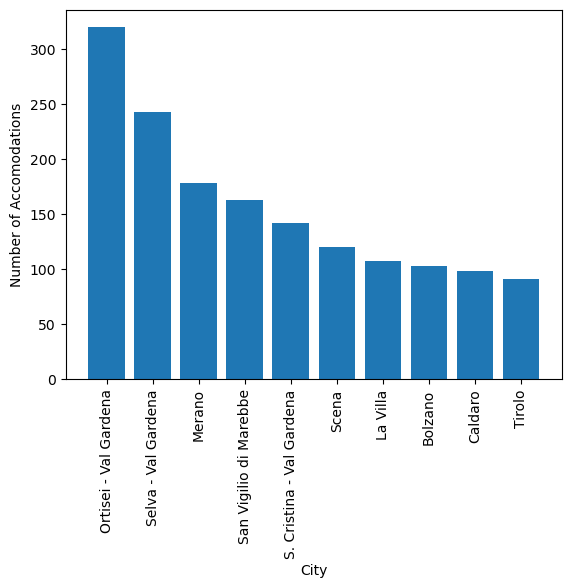

In [136]:
# Create a bar chart
plt.bar(df['city'], df['count'])
# Add x and y labels
plt.xlabel('City')
plt.ylabel('Number of Accomodations')
# Show the plot
plt.xticks(rotation=90)
plt.show()

In [132]:
# num of event per city
q = """
PREFIX event: <http://example.org/event#>
PREFIX location: <http://example.org/location#>
SELECT ?city (COUNT(?event) as ?count) 
WHERE {
    ?event event:ref-location_id ?location .
    ?location location:city ?city .
} GROUP BY ?city
ORDER BY DESC(?count)
LIMIT 10

"""

df = sparql_dataframe.get(endpoint, q)
df

/Users/edoardobianchi/miniforge3/envs/profiling/lib/python3.8/site-packages/SPARQLWrapper/Wrapper.py:1215: RuntimeWarning:

unknown response content type 'text/sparql-results+csv;charset=UTF-8' returning raw response...



,city,count
0,Merano,16
1,Dobbiaco,10
2,Selva,6
3,Sesto,4
4,Curon Venosta,4
5,Silandro,4
6,Sarentino,3
7,Villabassa,3
8,Valle Aurina,3
9,Racines,2


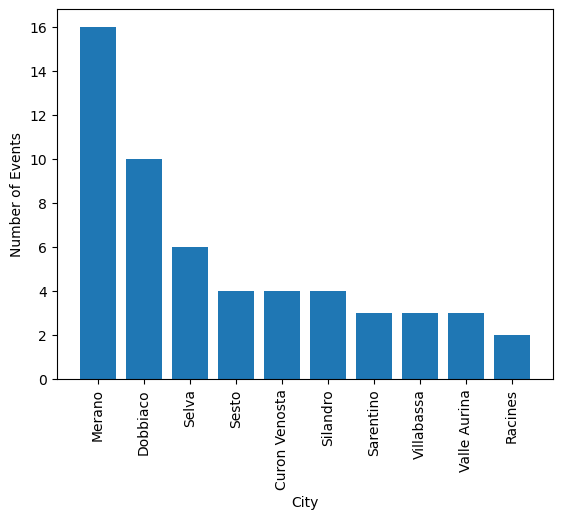

In [133]:
# Create a bar chart
plt.bar(df['city'], df['count'])
# Add x and y labels
plt.xlabel('City')
plt.ylabel('Number of Events')
# Show the plot
plt.xticks(rotation=90)
plt.show()

# Web Application

We used Streamlit to develop a simple webapp that allows to explore events and accomodations in South Tyrol. Results are proposed as visualizations (ex. histograms) and/or as tabular form. In order to run the application, one need first to deploy the SPARQL local endpoint and then run the following command: 
```
streamlit run app.py
```

The following images represent the application

# Conclusions

In this project we developed a simple application to discover events and accommodations in the region. The main challenges we faced related to data quality. In particular, the data cleaning phase took a lot of time. Using data profiling techniques, it was possible to discover more information about the data and decide how to process it.

Once the relational database was built, we modeled an application domain ontology that makes it possible to run SPARQL queries on the database without materializing an RDF graph. With this ontology, and the mappings, it is possible in the future to integrate new data (for example, from another region).